# Differential drive robot (i.e., "segbot") in artificial gravity

In [332]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import asyncio

# This is my own script (it is an interface to the pybullet simulator)
import ae353_segbot

In [333]:
simulator = ae353_segbot.Simulator(
    display=True,
    bumpy=True,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


In [334]:
slider = widgets.FloatSlider(
    value=0.,
    min=-3.,
    max=3.,
    step=0.01,
    description='Centerline:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='75%', border='solid 2px', margin='10px')
)

In [335]:
simulator.camera_backview()

## State Space Model Derivation

importing necessary packages and extensions

In [336]:
import sympy as sym
import numpy as np
from scipy import linalg
from scipy import signal
import random

## EQs of Motion, F, Equilibrium, A, B

constants

In [338]:
# Dimensions of chassis
dx = 0.4
dy = 0.6
dz = 0.8

# Distance between axle and COM of chassis
h = 0.3

# Half-distance between wheels
a = 0.7 / 2

# Mass of chassis
mb = 12.

# MOI of chassis
Jbx = (mb / 12) * (dy**2 + dz**2)
Jby = (mb / 12) * (dx**2 + dz**2)
Jbz = (mb / 12) * (dx**2 + dy**2)

# Radius of each wheel
r = 0.325

# Width of each wheel
hw = 0.075

# Mass of each wheel
mw = 1.2

# MOI of each wheel
Jw = (mw / 2) * r**2
Jwt = (mw / 12) * (3 * r**2 + hw**2)

# Total mass
m = mb + 2 * mw

equations of motion

In [339]:
# Total MOI
Jx = Jbx + 2 * Jwt
Jy = Jby
Jz = Jbz + 2 * Jwt

# Station parameters
station_velocity = -0.5 # <-- FIXME (change the velocity to change gravity)
station_radius = 20.    # <-- radius in meters of inside surface of station

# Acceleration of artifical gravity
g = station_velocity**2 * station_radius

# Dimensions
h = sym.nsimplify(h)
a = sym.nsimplify(a)
r = sym.nsimplify(r)

# Masses
mb = sym.nsimplify(mb)
mw = sym.nsimplify(mw)
m = sym.nsimplify(m)

# MOIs
Jx = sym.nsimplify(Jx)
Jy = sym.nsimplify(Jy)
Jz = sym.nsimplify(Jz)
Jw = sym.nsimplify(Jw)
Jwt = sym.nsimplify(Jwt)

# Gravity
g = sym.nsimplify(g)

(e_l,
 e_h,
 v,
 w,
 theta,
 thetadot,
 tau_R,
 tau_L) = sym.symbols('e_l, e_h, v, w, theta, thetadot, tau_R, tau_L', real=True)

M = sym.Matrix([[m + 2 * Jw / r**2, 0, mb * h * sym.cos(theta)],
                [0, (Jx + mb * h**2) * sym.sin(theta)**2 + Jz * sym.cos(theta)**2 + (2 * Jw * a**2 / r**2) + 2 * mw * a**2, 0],
                [mb * h * sym.cos(theta), 0, Jy * mb * h**2]])
N = sym.Matrix([[mb * h * (w**2 + thetadot**2) * sym.sin(theta)],
                [-2 * (Jx - Jz + m * h**2) * sym.cos(theta) * sym.sin(theta) * w * thetadot - mb * h * sym.sin(theta) * v * w],
                [(Jx - Jz + mb * h**2) * sym.cos(theta) * sym.sin(theta) * w**2 + mb * g * h * sym.sin(theta)]])
R = sym.Matrix([[1 / r, 1 / r],
                [-a / r, a / r],
                [-1, -1]])
f = sym.simplify(M.inv() * (N + R * sym.Matrix([[tau_L], [tau_R]])))

f = sym.Matrix([[v * sym.sin(e_h)],
                [w],
                [f]])

In [340]:
# taking f and creating fnew which has all first order ODEs

phi, phidot = sym.symbols('phi, phidot')
fnew = sym.Matrix([[f[0]], [f[1]], [f[2]], [f[3]], [phi], [f[4]]])

# equilibrium values of each variable, calculated by hand
e_le = 0
e_he = 0 # angle
ve = 2
we = 0
phie = 0 # angle
phidote = 0
tau_Re = 0
tau_Le = 0

A_num = sym.lambdify((e_l,e_h, v, w, theta, thetadot, tau_R, tau_L), fnew.jacobian([e_l, e_h, v, w, theta, thetadot]))
B_num = sym.lambdify((e_l,e_h, v, w, theta, thetadot, tau_R, tau_L), fnew.jacobian([tau_R, tau_L]))

A = A_num(e_le, e_he, ve, we, phie, phidote, tau_Re, tau_Le)
B = B_num(e_le, e_he, ve, we, phie, phidote, tau_Re, tau_Le)

A = A.astype(float)
B = B.astype(float)

below is the f value with first order ODEs

In [341]:
fnew

Matrix([
[                                                                                                                                                                           v*sin(e_h)],
[                                                                                                                                                                                    w],
[        -(1200*tau_L + 1200*tau_R + 1404*(thetadot**2 + w**2)*sin(theta) + 65*(50*tau_L + 50*tau_R - 39*w**2*sin(2*theta) - 900*sin(theta))*cos(theta)/2)/(5850*cos(theta)**2 - 6084)],
[                                                                    32*(-875*tau_L + 875*tau_R - 1443*thetadot*w*sin(2*theta) - 2925*v*w*sin(theta))/(13*(3120*sin(theta)**2 + 2051))],
[                                                                                                                                                                                  phi],
[5*(4225*tau_L + 4225*tau_R - 6591*w**2*sin(2*theta)/2 + 30*(100*t

A and B values

In [342]:
A, B

(array([[   0.        ,    2.        ,    0.        ,    0.        ,
            0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,    1.        ,
            0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ,
         -125.        ,   -0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,   -0.        ,
          541.66666667,   -0.        ]]),
 array([[  0.        ,   0.        ],
        [  0.        ,   0.        ],
        [ 12.07264957,  12.07264957],
        [  1.05014439,  -1.05014439],
        [  0.        ,   0.        ],
        [-51.46011396, -51.46011396]]))

## Finding K through LQR
also reformatting A, B in easy to read format

In [343]:
Am = sym.Matrix(A)
Bm = sym.Matrix(B)
A[4][5] = 1

def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @ B.T @ P
    return K

In [344]:
Am, Bm # printing to easily read out A and B values

(Matrix([
 [0, 2.0, 0,   0,                0, 0],
 [0,   0, 0, 1.0,                0, 0],
 [0,   0, 0,   0,           -125.0, 0],
 [0,   0, 0,   0,                0, 0],
 [0,   0, 0,   0,                0, 0],
 [0,   0, 0,   0, 541.666666666667, 0]]),
 Matrix([
 [               0,                 0],
 [               0,                 0],
 [12.0726495726496,  12.0726495726496],
 [1.05014439485429, -1.05014439485429],
 [               0,                 0],
 [-51.460113960114,  -51.460113960114]]))

## Q Matrix Depiction
LQR Q matrix representation to visualize state weight matrix

In [345]:
q1, q2, q3, q4, q5, q6 = sym.symbols('Q_1, Q_2, Q_3, Q_4, Q_5, Q_6')
Qs = np.diag([q1, q2, q3, q4, q5, q6])
Qs = sym.Matrix(Qs)
Qs

Matrix([
[Q_1,   0,   0,   0,   0,   0],
[  0, Q_2,   0,   0,   0,   0],
[  0,   0, Q_3,   0,   0,   0],
[  0,   0,   0, Q_4,   0,   0],
[  0,   0,   0,   0, Q_5,   0],
[  0,   0,   0,   0,   0, Q_6]])

## Q and R Matrix, LQR
Defining Q, R values and solving LQR

In [346]:
# Q1-6 are weights, defined in comments

Q1 = 5 # lateral error
Q2 = 1 # heading error
Q3 = 1 # forward velocity
Q4 = 1 # turning rate
Q5 = 5 # pitch angle
Q6 = 5 # pitch rate

Q = np.diag([Q1, Q2, Q3, Q4, Q5, Q6])
R = np.eye(2)

lqr_ans = lqr(A, B, Q, R)
lqr_ans # printing to read out

array([[  1.58113883,   3.61315385,  -0.70710678,   1.98510094,
        -11.22544804,  -1.8228914 ],
       [ -1.58113883,  -3.61315385,  -0.70710678,  -1.98510094,
        -11.22544804,  -1.8228914 ]])

In [347]:
Q # to read out Q

array([[5, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 5, 0],
       [0, 0, 0, 0, 0, 5]])

controller class implementation

In [348]:
class Controller:
    def __init__(self):
        pass
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            lateral_error,
            heading_error,
            forward_speed,
            turning_rate,
            pitch_angle,
            pitch_rate,
        ):
        
        # FIXME: replace the following lines
        
        k = np.array(lqr_ans)
        x = np.array([[lateral_error], [heading_error], [forward_speed], [turning_rate], [pitch_angle], [pitch_rate]])
        
        u = -k@x
        
        right_wheel_torque = u[0][0]
        left_wheel_torque = u[1][0]
        
        return right_wheel_torque, left_wheel_torque

In [349]:
controller = Controller()

all initial conditions = 0 except v = 2

new sim protocol - reset everything

In [350]:
simulator.reset(
    initial_speed=2.0,
    initial_lateral_error=0.0,
    initial_heading_error=0.0,
    initial_pitch=0,
    station_velocity=-0.5,
)

In [351]:
controller.reset()

In [352]:
slider.value = 0.

15 second simulation 

In [353]:
# Show the slider, to allow steering the robot
display(slider)

# Run the simulation asynchronously, to allow using the slider
obj = asyncio.ensure_future(
    simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=60,         # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
        slider=slider,        # <-- optional (allow steering)
        print_debug=True,     # <-- optional (say when the simulator has finished running)
    )
)

FloatSlider(value=0.0, description='Centerline:', layout=Layout(border_bottom='solid 2px', border_left='solid …

Get data from sim post run

In [219]:
if obj.done():
    data = obj.result()
else:
    print('You cannot get results until after the simulator is done running.')

picture of bot at end

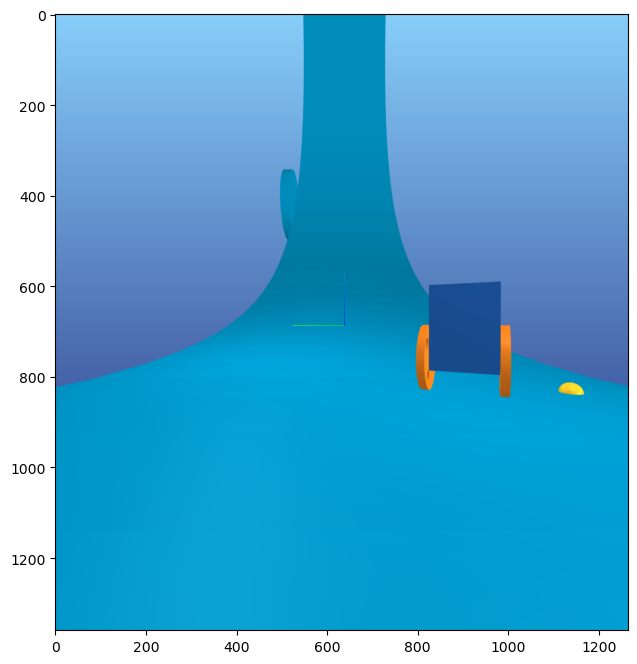

In [220]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

plotting results

(0.0, 15.0)

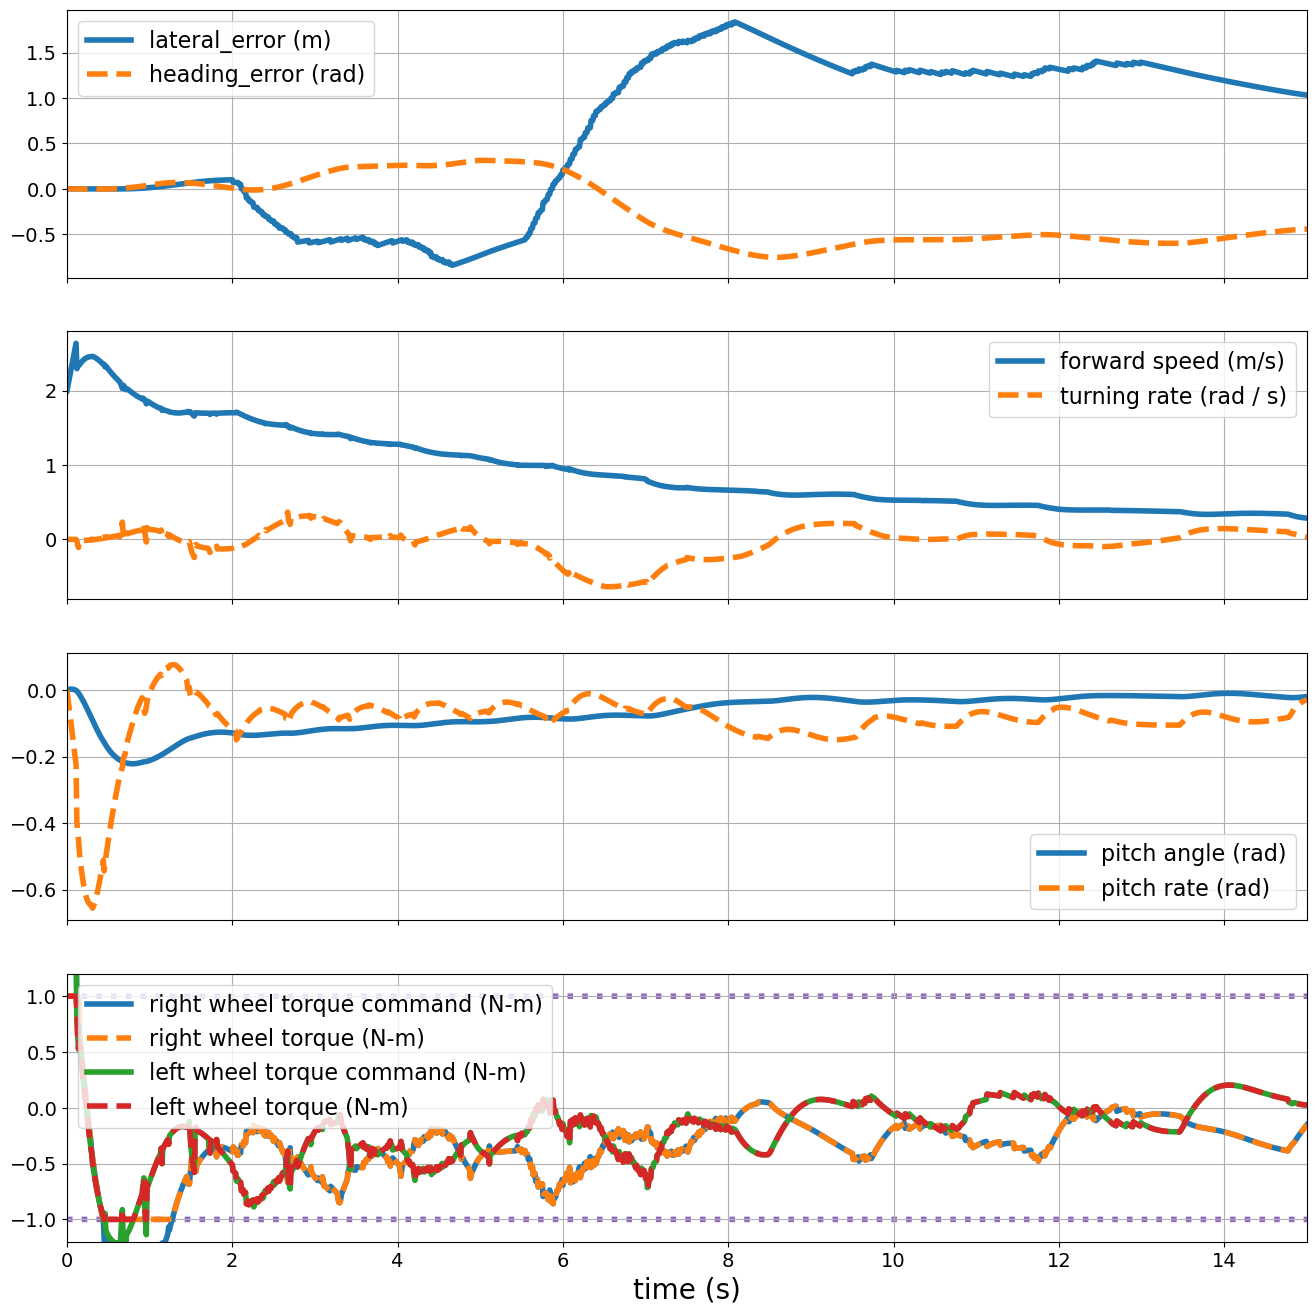

In [224]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_pos, ax_vel, ax_pitch, ax_torque) = plt.subplots(4, 1, figsize=(16, 16), sharex=True)

# Plot lateral and heading error
ax_pos.plot(
    data['t'], data['lateral_error'],
    label='lateral_error (m)', linewidth=4,
)
ax_pos.plot(
    data['t'], data['heading_error'],
    '--', label='heading_error (rad)', linewidth=4,
)
ax_pos.grid()
ax_pos.legend(fontsize=16)
ax_pos.tick_params(labelsize=14)

# Plot forward speed and turning rate
ax_vel.plot(
    data['t'], data['forward_speed'],
    label='forward speed (m/s)', linewidth=4,
)
ax_vel.plot(
    data['t'], data['turning_rate'],
    '--', label='turning rate (rad / s)', linewidth=4,
)
ax_vel.grid()
ax_vel.legend(fontsize=16)
ax_vel.tick_params(labelsize=14)

# Plot pitch angle and pitch rate
ax_pitch.plot(
    data['t'], data['pitch_angle'],
    label='pitch angle (rad)', linewidth=4,
)
ax_pitch.plot(
    data['t'], data['pitch_rate'],
    '--', label='pitch rate (rad)', linewidth=4,
)
ax_pitch.grid()
ax_pitch.legend(fontsize=16)
ax_pitch.tick_params(labelsize=14)

# Plot torques
ax_torque.plot(
    data['t'], data['right_wheel_torque_command'],
    label='right wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['right_wheel_torque'],
    '--', label='right wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque_command'],
    label='left wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque'],
    '--', label='left wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=16)
ax_torque.tick_params(labelsize=14)
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
# fig.tight_layout()

## Numerical Verification of Requirement
obtain max and min values of pitch angle data array

take absolute value of each, determine absolute max pitch angle for simulation

In [225]:
abs(max(data["pitch_angle"])), abs(min(data["pitch_angle"]))

(0.00342946714366193, 0.22139189663333053)

Save the figure (without transparent background).

In [20]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

## Easy to Run Iterations

In [261]:
A, B

(array([[   0.        ,    2.        ,    0.        ,    0.        ,
            0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,    1.        ,
            0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ,
         -125.        ,   -0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    1.        ],
        [   0.        ,    0.        ,    0.        ,   -0.        ,
          541.66666667,   -0.        ]]),
 array([[  0.        ,   0.        ],
        [  0.        ,   0.        ],
        [ 12.07264957,  12.07264957],
        [  1.05014439,  -1.05014439],
        [  0.        ,   0.        ],
        [-51.46011396, -51.46011396]]))

basically, combined all the code it takes to modify Q matrix and then run simulation

In [262]:
Q1 = 1
Q2 = 1
Q3 = 1
Q4 = 1
Q5 = 1
Q6 = 5

Q = np.diag([Q1, Q2, Q3, Q4, Q5, Q6]) # state weight matrix
R = np.eye(2) # input weight matrix

lqr_k = lqr(A, B, Q, R)

# running sim code with K
class Controller:
    def __init__(self):
        pass
    
    def reset(self):
        pass
    
    def run(
        self,
        t,
        lateral_error,
        heading_error,
        forward_speed,
        turning_rate,
        pitch_angle,
        pitch_rate,
    ):
        
    # FIXME: replace the following lines
        
        k = lqr_k
        x = np.array([[lateral_error], [heading_error], [forward_speed], [turning_rate], [pitch_angle], [pitch_rate]])
        
        u = -k@x
        
        right_wheel_torque = u[0][0]
        left_wheel_torque = u[1][0]
        
        return right_wheel_torque, left_wheel_torque
    
controller = Controller()
slider.value = 0.

simulator.reset(
    initial_speed=2,
    initial_lateral_error=0.,
    initial_heading_error=0.,
    initial_pitch=0.,
    station_velocity=-0.5,
)

controller.reset()

# Run the simulation asynchronously, to allow using the slider
obj = asyncio.ensure_future(
simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=10.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
    slider=slider,        # <-- optional (allow steering)
    print_debug=True,     # <-- optional (say when the simulator has finished running)
    )
)

In [265]:
if obj.done():
    data = obj.result()
    print("Home Cooked Dinner")
else:
    print("unlucko, wait a lil longer")

Home Cooked Dinner


## Display Data
code for displaying data

(0.0, 5.0)

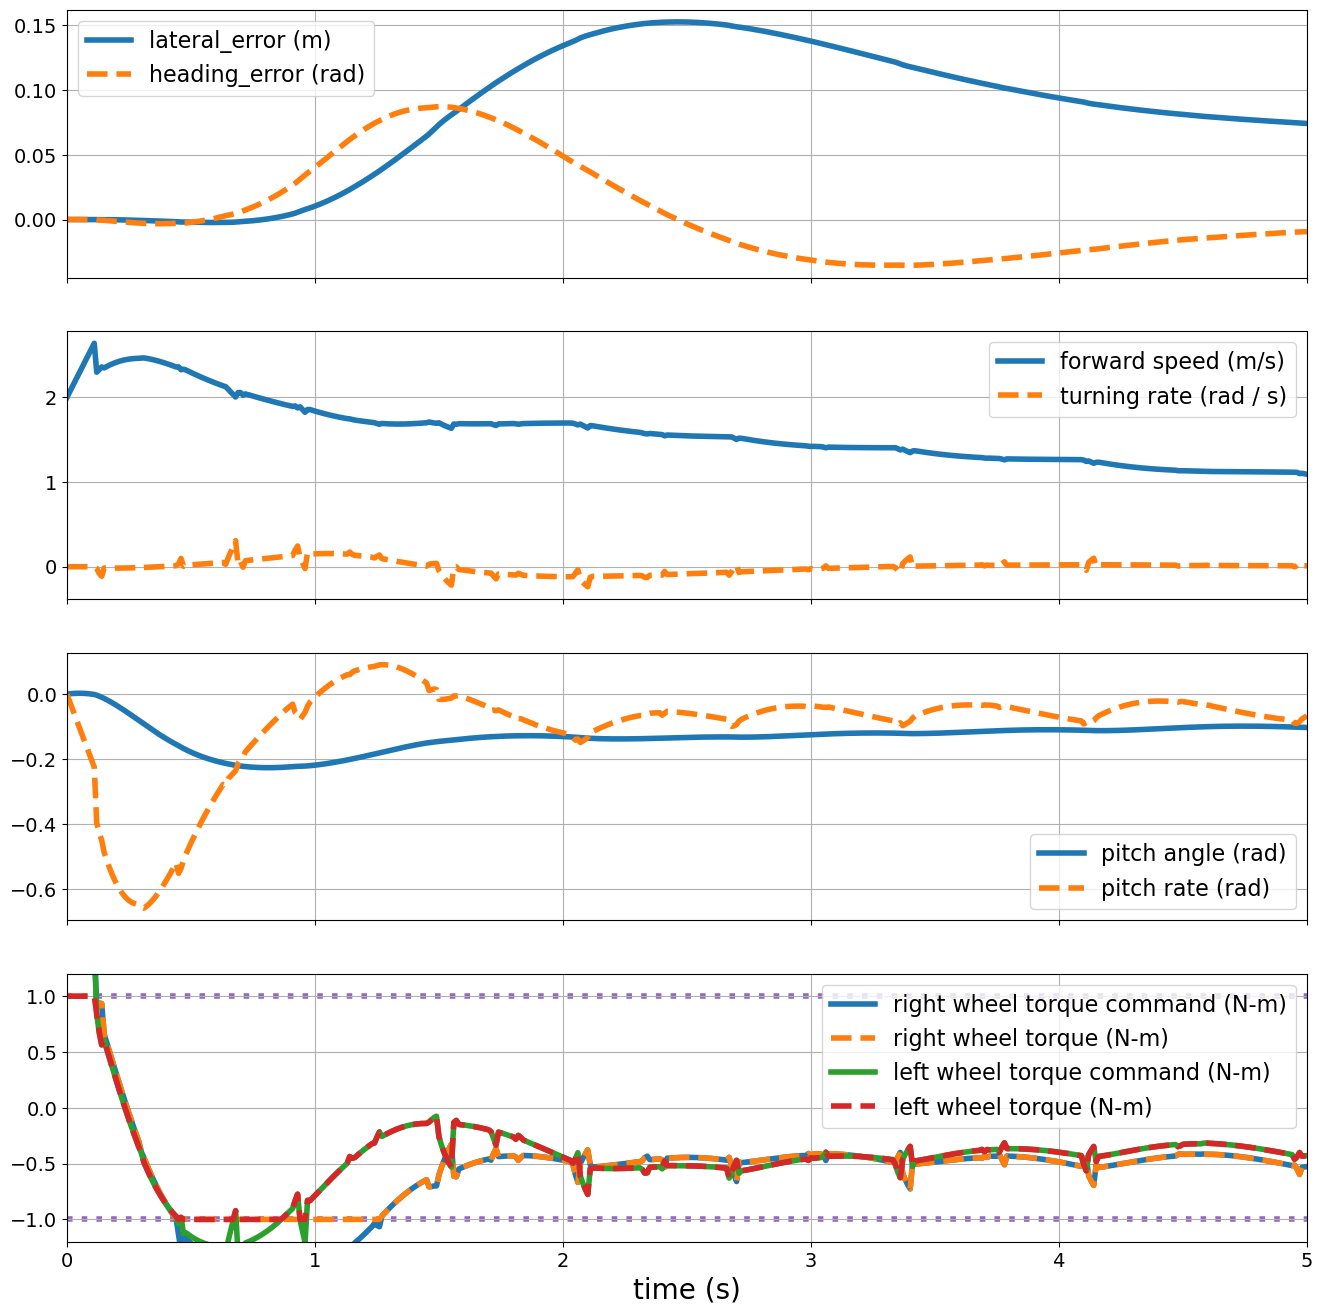

In [87]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_pos, ax_vel, ax_pitch, ax_torque) = plt.subplots(4, 1, figsize=(16, 16), sharex=True)

# Plot lateral and heading error
ax_pos.plot(
    data['t'], data['lateral_error'],
    label='lateral_error (m)', linewidth=4,
)
ax_pos.plot(
    data['t'], data['heading_error'],
    '--', label='heading_error (rad)', linewidth=4,
)
ax_pos.grid()
ax_pos.legend(fontsize=16)
ax_pos.tick_params(labelsize=14)

# Plot forward speed and turning rate
ax_vel.plot(
    data['t'], data['forward_speed'],
    label='forward speed (m/s)', linewidth=4,
)
ax_vel.plot(
    data['t'], data['turning_rate'],
    '--', label='turning rate (rad / s)', linewidth=4,
)
ax_vel.grid()
ax_vel.legend(fontsize=16)
ax_vel.tick_params(labelsize=14)

# Plot pitch angle and pitch rate
ax_pitch.plot(
    data['t'], data['pitch_angle'],
    label='pitch angle (rad)', linewidth=4,
)
ax_pitch.plot(
    data['t'], data['pitch_rate'],
    '--', label='pitch rate (rad)', linewidth=4,
)
ax_pitch.grid()
ax_pitch.legend(fontsize=16)
ax_pitch.tick_params(labelsize=14)

# Plot torques
ax_torque.plot(
    data['t'], data['right_wheel_torque_command'],
    label='right wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['right_wheel_torque'],
    '--', label='right wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque_command'],
    label='left wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque'],
    '--', label='left wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=16)
ax_torque.tick_params(labelsize=14)
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
# fig.tight_layout()